# Find Wally

This notebook was last executed with just a small test subset of the data

# Imports

In [1]:
from fastai.vision.all import *
import os
import pandas as pd
import zipfile
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import pickle

C:\Users\Tom\.conda\envs\tensorflow_gpu\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Import files

In [2]:
files = get_image_files("lumos_datathon/archive/img_align_celeba")
len(files)

202599

# Exclude evaluation data

In [3]:
f_eval = pd.read_csv("eval_data_public.csv")
df_train = pd.read_csv("train_data.csv")
df_att = pd.read_csv("list_attr_celeba.csv").set_index("image_id")
df_att = df_att.replace({-1:0})
columns = df_att.columns

def get_labels(row):
    return ",".join(list(columns[row]))


df_eval = pd.read_csv("eval_data_public.csv")
s_eval = df_eval.set_index("id")["16_image_ids"]
df_train = df_train.set_index("id")[["16_image_ids","anomalous_image_id","attributes"]]
for col in columns:
    df_att[col] = df_att[col].apply(bool)
    
eval_set = set()
for idx in range(len(df_eval)):
    ids = df_eval.iloc[idx]["16_image_ids"].split(" ")
    eval_set = set.union(set(ids))
    
train_labels = list(set(df_att.index).difference(eval_set))
val_labels = list(eval_set)

# Define ImageDataLoaders for fast ai

In [4]:
all_label_list = list(df_att.apply(get_labels,axis=1))
train_label_list = list(df_att.loc[train_labels].apply(get_labels,axis=1))
val_label_list = list(df_att.loc[val_labels].apply(get_labels,axis=1))

path = "lumos_datathon/archive/img_align_celeba"
df_train2 = pd.DataFrame.from_dict({"name": train_labels, "labels": train_label_list})
train_dls = ImageDataLoaders.from_df(df_train2, path,label_delim=",")

full_df = pd.DataFrame.from_dict({"name": list(df_att.index), "labels": all_label_list})
full_dls = ImageDataLoaders.from_df(full_df, path,label_delim=",")

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck
Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


# Define Metrics and finetune the resnet34

In [5]:
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
learn = vision_learner(train_dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.5) ,f1_macro,  f1_samples])

# learn.lr_find()
learn.fine_tune(6, 0.003)

C:\Users\Tom\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\Tom\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,1.072916,1.371383,0.462500,0.205903,0.295294,00:02


epoch,train_loss,valid_loss,accuracy_multi,F1(macro),F1(samples),time
0,1.066603,1.217375,0.461250,0.211469,0.300002,00:00


#

C:\Users\Tom\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1592: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,target,predicted,probabilities,loss
0,Bags_Under_Eyes;Bald;Big_Nose;Gray_Hair;Male;Oval_Face;Receding_Hairline;Sideburns;Wearing_Necktie,5_o_Clock_Shadow;Bald;Bangs;Black_Hair;Brown_Hair;Double_Chin;Goatee;Gray_Hair;Heavy_Makeup;High_Cheekbones;Male;Mouth_Slightly_Open;Narrow_Eyes;Pale_Skin;Pointy_Nose;Rosy_Cheeks;Smiling;Straight_Hair;Wearing_Lipstick;Wearing_Necktie;Young,"TensorBase([8.9215e-01, 1.5946e-01, 3.9591e-02, 1.0789e-02, 5.8065e-01,\n 8.9899e-01, 2.2301e-01, 2.3429e-03, 8.2378e-01, 1.0517e-01,\n 3.8328e-02, 7.5696e-01, 9.6735e-02, 2.4776e-01, 5.1961e-01,\n 1.1562e-01, 8.9481e-01, 7.2527e-01, 9.9173e-01, 9.7988e-01,\n 6.6872e-01, 9.5364e-01, 1.9733e-01, 8.7378e-01, 3.2224e-01,\n 6.8212e-04, 6.0692e-01, 9.1302e-01, 2.0319e-01, 8.4475e-01,\n 7.1969e-02, 9.8697e-01, 9.7335e-01, 4.1162e-01, 4.9868e-01,\n 2.9044e-02, 8.4701e-01, 4.8172e-01, 9.7698e-01, 9.1981e-01])",1.7283836603164673
1,High_Cheekbones;Mouth_Slightly_Open;No_Beard;Smiling;Wearing_Earrings;Wearing_Hat;Young,5_o_Clock_Shadow;Bald;Big_Lips;Big_Nose;Black_Hair;Blond_Hair;Brown_Hair;Chubby;Double_Chin;Eyeglasses;Goatee;Gray_Hair;Heavy_Makeup;High_Cheekbones;Male;Mouth_Slightly_Open;Mustache;Pale_Skin;Pointy_Nose;Rosy_Cheeks;Sideburns;Smiling;Straight_Hair;Wearing_Lipstick;Young,"TensorBase([0.9218, 0.1982, 0.0276, 0.3667, 0.5796, 0.2305, 0.8801, 0.7011,\n 0.6776, 0.9831, 0.0033, 0.9519, 0.0103, 0.9279, 0.9065, 0.9412,\n 0.9568, 0.7768, 0.9887, 0.7133, 0.9313, 0.9651, 0.9589, 0.1516,\n 0.3265, 0.0150, 0.6379, 0.8538, 0.4119, 0.9512, 0.9191, 0.9175,\n 0.9832, 0.4881, 0.0065, 0.3931, 0.9855, 0.0097, 0.2560, 0.9205])",1.622686743736267
2,Attractive;Bangs;Blond_Hair;Heavy_Makeup;High_Cheekbones;Mouth_Slightly_Open;No_Beard;Oval_Face;Pointy_Nose;Smiling;Wavy_Hair;Wearing_Lipstick;Young,Arched_Eyebrows;Bald;Black_Hair;Brown_Hair;Chubby;Double_Chin;Goatee;Gray_Hair;Heavy_Makeup;Mustache;Narrow_Eyes;No_Beard;Pointy_Nose;Receding_Hairline;Rosy_Cheeks;Sideburns;Smiling;Wavy_Hair;Wearing_Hat;Wearing_Lipstick;Young,"TensorBase([6.1268e-02, 8.5124e-01, 7.6169e-02, 9.9361e-02, 9.5438e-01,\n 2.9965e-02, 1.5553e-02, 3.1471e-02, 7.1394e-01, 3.7608e-01,\n 6.6152e-04, 9.1974e-01, 1.0454e-01, 9.8801e-01, 9.6616e-01,\n 1.3981e-03, 6.2513e-01, 8.8521e-01, 9.9893e-01, 1.0327e-01,\n 1.4014e-02, 4.0465e-01, 9.9176e-01, 9.6485e-01, 5.7567e-01,\n 4.2613e-01, 2.9428e-01, 9.8154e-01, 8.8997e-01, 9.8817e-01,\n 7.3727e-01, 7.9834e-01, 2.0889e-02, 9.3891e-01, 1.5118e-03,\n 9.9920e-01, 9.1303e-01, 1.5548e-03, 3.0442e-01, 5.9726e-01])",1.4152272939682007
3,Arched_Eyebrows;Big_Lips;Black_Hair;Bushy_Eyebrows;Male;No_Beard;Young,5_o_Clock_Shadow;Arched_Eyebrows;Bald;Big_Nose;Blond_Hair;Brown_Hair;Chubby;Double_Chin;Goatee;Gray_Hair;Heavy_Makeup;Mouth_Slightly_Open;Mustache;Pale_Skin;Pointy_Nose;Receding_Hairline;Rosy_Cheeks;Smiling;Straight_Hair;Wavy_Hair;Wearing_Lipstick;Wearing_Necktie;Young,"TensorBase([0.9337, 0.6732, 0.1529, 0.0173, 0.9754, 0.1070, 0.0442, 0.5115,\n 0.1474, 0.7472, 0.0349, 0.6188, 0.2129, 0.7446, 0.9227, 0.1761,\n 0.9711, 0.7664, 0.6903, 0.1299, 0.1131, 0.9166, 0.5033, 0.1279,\n 0.2237, 0.0151, 0.9813, 0.8881, 0.5619, 0.8864, 0.1546, 0.8152,\n 0.9609, 0.9444, 0.0150, 0.4508, 0.9336, 0.2442, 0.5852, 0.7187])",1.4049748182296753
4,Bangs;Black_Hair;Heavy_Makeup;Mouth_Slightly_Open;No_Beard;Wearing_Earrings;Wearing_Lipstick;Young,Arched_Eyebrows;Attractive;Bald;Big_Lips;Blond_Hair;Brown_Hair;Chubby;Double_Chin;Eyeglasses;Gray_Hair;Heavy_Makeup;High_Cheekbones;Male;Mustache;Pale_Skin;Pointy_Nose;Rosy_Cheeks;Sideburns;Smiling;Straight_Hair;Wavy_Hair;Wearing_Lipstick;Young,"TensorBase([2.3177e-01, 8.7557e-01, 6.7051e-01, 1.6454e-01, 6.8661e-01,\n 5.5270e-02, 6.6542e-01, 7.3180e-02, 1.0901e-02, 9.4671e-01,\n 3.1602e-04, 6.9975e-01, 9.1024e-02, 9.1329e-01, 8.0182e-01,\n 5.4402e-01, 2.0148e-01, 6.9132e-01, 8.7059e-01, 7.0921e-01,\n 6.6956e-01, 2.6936e-01, 6.3952e-01, 3.3591e-01, 1.3690e-01,\n 1.0211e-02, 8.4651e-01, 9.3906e-01, 2.5812e-01, 9.3210e-01,\n 9.7873e-01, 9.7918e-01, 8.629

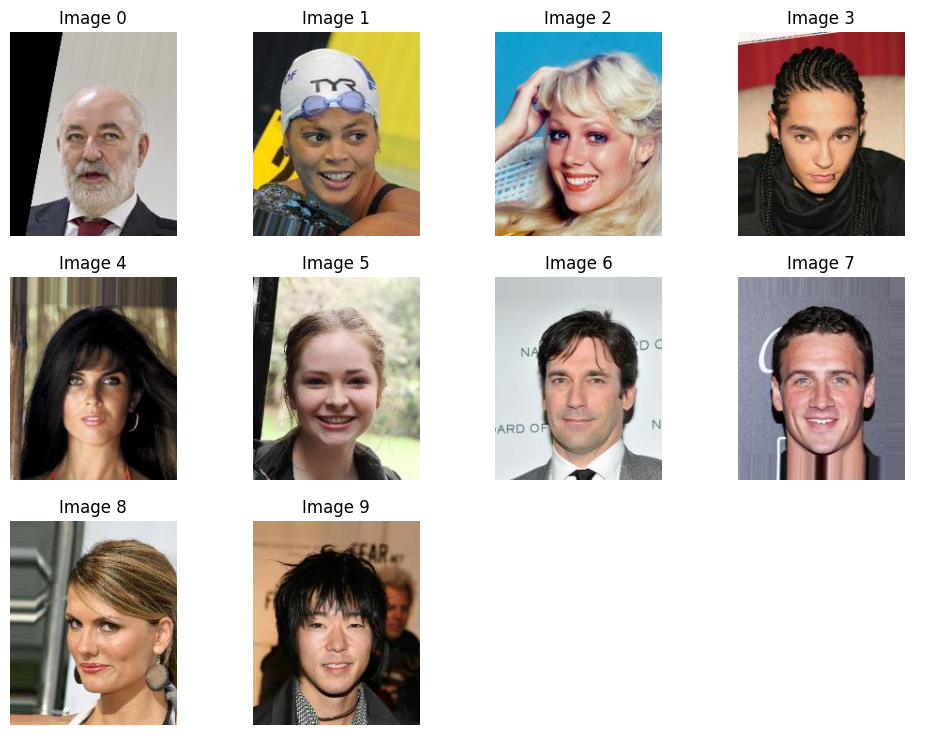

In [6]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(10)

# Export model

In [8]:
learn.export(f"{os.getcwd()}/learners/multi_model_no_eval.pkl")

# Make predictions

TensorBase([[0.2420, 0.6672, 0.6139,  ..., 0.1990, 0.6969, 0.3522],
            [0.7219, 0.5192, 0.7495,  ..., 0.2070, 0.6667, 0.8257],
            [0.1981, 0.8082, 0.3123,  ..., 0.1024, 0.0739, 0.9251],
            ...,
            [0.6685, 0.2104, 0.4094,  ..., 0.3941, 0.4286, 0.7923],
            [0.7949, 0.6143, 0.7199,  ..., 0.4043, 0.7845, 0.1972],
            [0.1902, 0.6421, 0.3155,  ..., 0.6651, 0.1032, 0.2575]])

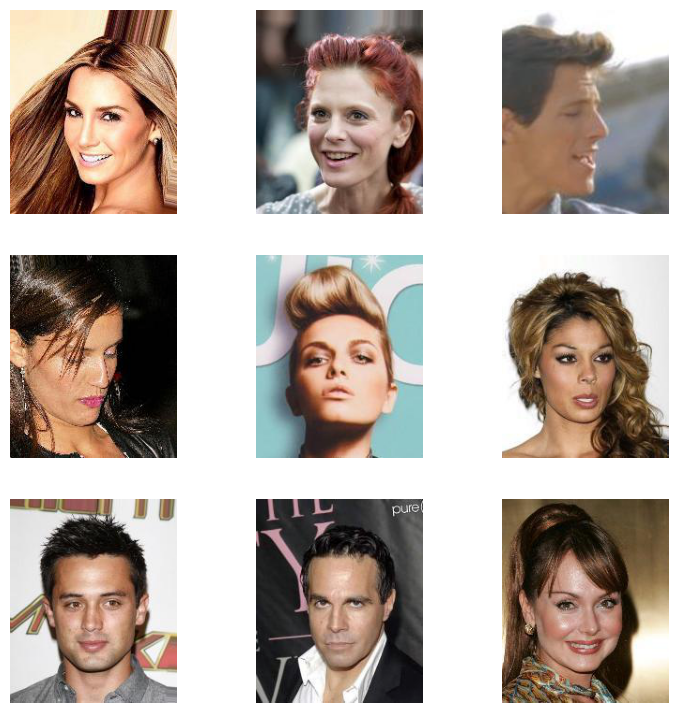

In [9]:
dl = learn.dls.test_dl(files)
dl.show_batch()
preds = learn.get_preds(dl=dl)
preds = preds[0]
preds

# Save predictions

In [10]:
with open('tensorpreds_all_no_eval.pkl', 'wb') as handle:
    pickle.dump(preds, handle, protocol=pickle.HIGHEST_PROTOCOL)
series_preds = pd.DataFrame.from_dict({"name":list(df_att.index),"preds":list(preds)}).set_index("name")["preds"]

# Pytorch


In [11]:
df_train

,16_image_ids,anomalous_image_id,attributes
id,,,
0,075032.jpg 057548.jpg 017891.jpg 150729.jpg 166192.jpg 069176.jpg 100406.jpg 110530.jpg 171966.jpg 001858.jpg 155621.jpg 108536.jpg 039539.jpg 078512.jpg 099258.jpg 164343.jpg,110530.jpg,Wearing_Lipstick & No_Beard
1,184184.jpg 183772.jpg 181738.jpg 173668.jpg 116081.jpg 131799.jpg 106674.jpg 041783.jpg 180043.jpg 095197.jpg 175695.jpg 186817.jpg 116152.jpg 000935.jpg 004634.jpg 160687.jpg,183772.jpg,Mustache & Wearing_Necktie
2,098448.jpg 095288.jpg 009278.jpg 196781.jpg 093051.jpg 189996.jpg 180244.jpg 128796.jpg 186708.jpg 093330.jpg 186498.jpg 158603.jpg 199792.jpg 125793.jpg 138178.jpg 178804.jpg,125793.jpg,Narrow_Eyes & Smiling
3,172915.jpg 050582.jpg 130960.jpg 060347.jpg 107877.jpg 196399.jpg 079850.jpg 150665.jpg 063196.jpg 033723.jpg 142405.jpg 133326.jpg 018141.jpg 118520.jpg 101665.jpg 184227.jpg,133326.jpg,Smiling & Black_Hair
4,168629.jpg 071757.jpg 129313.jpg 046807.jpg 198795.jpg 111992.jpg 123593.jpg 036405.jpg 194960.jpg 086177.jpg 125653.jpg 122099.jpg 178965.jpg 051161.jpg 057724.jpg 058952.jpg,194960.jpg,Bald & Wearing_Necktie
...,...,...,...
157687,176159.jpg 046275.jpg 149660.jpg 042760.jpg 089232.jpg 089401.jpg 030232.jpg 001355.jpg 130844.jpg 070744.jpg 000749.jpg 023755.jpg 196944.jpg 137214.jpg 161504.jpg 143683.jpg,130844.jpg,Brown_Hair & Wearing_Hat
157688,089214.jpg 124555.jpg 100755.jpg 153763.jpg 164351.jpg 117693.jpg 194375.jpg 165804.jpg 070559.jpg 000387.jpg 128989.jpg 163522.jpg 065616.jpg 019179.jpg 044877.jpg 022318.jpg,022318.jpg,High_Cheekbones & Bags_Under_Eyes
157689,084122.jpg 076608.jpg 198658.jpg 009102.jpg 038576.jpg 193202.jpg 025784.jpg 008978.jpg 131890.jpg 002135.jpg 044387.jpg 041568.jpg 016107.jpg 119852.jpg 057485.jpg 175081.jpg,002135.jpg,Blond_Hair & Attractive


# Define the dataset and create dataloaders

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

def get_tensor_from_traindf(row):
    return torch.tensor(np.array([xid == row["anomalous_image_id"] for xid in row["16_image_ids"].split(" ")]).astype(float))
target_series = df_train.apply(get_tensor_from_traindf,axis=1)
df_train["target_series"]=target_series


learning_rate = 1e-3
batch_size = 64

class CustomDataset(Dataset):
    def __init__(self, series_preds, df_train):
        self.series_preds = series_preds
        self.df_train= df_train


    def __len__(self):
        return len(self.df_train)

    def __getitem__(self, idx):
        row = self.df_train.iloc[idx]
        image_ids = row["16_image_ids"].split(" ")
        target = row["target_series"]
        inp = torch.tensor(np.concatenate(self.series_preds.loc[image_ids]))
        return inp, target


# MAX_LEN = 10000
MAX_LEN = 157692
arr = np.arange(MAX_LEN)
np.random.shuffle(arr)
train_idx, val_idx = arr[:int(MAX_LEN*0.95)],arr[int(MAX_LEN*0.95):MAX_LEN]
train_dataset = CustomDataset(series_preds=series_preds,df_train=df_train.iloc[train_idx])
val_dataset = CustomDataset(series_preds=series_preds,df_train=df_train.iloc[val_idx])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Using cuda device


# Define training and evaluation 

### of Neural Network that takes in label probabilities of 16 images and predicts the anomaly

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16*40, 320),
            nn.ReLU(),
            nn.Linear(320, 160),
            nn.ReLU(),
            nn.Linear(160, 16),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X=X.to(device)
        y=y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X=X.to(device)
            y=y.to(device)
            pred = model(X)
            # print(pred.argmax(1))
            # print(y.argmax(1))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    


# Train

In [14]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.773592  [    0/149807]
loss: 2.775263  [ 6400/149807]
loss: 2.777140  [12800/149807]
loss: 2.764701  [19200/149807]
loss: 2.770461  [25600/149807]
loss: 2.775662  [32000/149807]
loss: 2.771941  [38400/149807]
loss: 2.772943  [44800/149807]
loss: 2.774272  [51200/149807]
loss: 2.774633  [57600/149807]
loss: 2.767093  [64000/149807]
loss: 2.770158  [70400/149807]
loss: 2.773284  [76800/149807]
loss: 2.779311  [83200/149807]
loss: 2.771104  [89600/149807]
loss: 2.773602  [96000/149807]
loss: 2.776407  [102400/149807]
loss: 2.771600  [108800/149807]
loss: 2.773248  [115200/149807]
loss: 2.775882  [121600/149807]
loss: 2.772960  [128000/149807]
loss: 2.774206  [134400/149807]
loss: 2.774302  [140800/149807]
loss: 2.772699  [147200/149807]
Test Error: 
 Accuracy: 6.0%, Avg loss: 2.772784 

Done!


# Save model

In [15]:
torch.save(model,"models/ep9_noleak.pkl")

# Inference

In [16]:
tensors=[]
for idx in range(len(df_eval)):
    row = df_eval.iloc[idx]
    image_ids = row["16_image_ids"].split(" ")
    inp = torch.tensor(np.concatenate(series_preds.loc[image_ids])).reshape((1,640))
    tensors.append(inp)
    
tensors = torch.cat(tensors,dim=0)
tensors = tensors.to(device)
with torch.no_grad():
    eval_preds = model(tensors)
eval_label_list = list(eval_preds.argmax(1))
eval_label_list = [x.item() for x in eval_label_list]
result_df = pd.DataFrame.from_dict({"id":list(df_eval.index),"anomalous_image_index":eval_label_list})
result_df = result_df.set_index("id")

# Save dataframe ready for submission

In [17]:
result_df.to_csv("result_csvs/ep9_noleak.csv")

# Misc

### Testing how many labels are in df_eval

In [18]:
df_eval

,Unnamed: 0,id,16_image_ids
0,0,0,043074.jpg 098193.jpg 057228.jpg 177965.jpg 107169.jpg 201854.jpg 010791.jpg 173536.jpg 016290.jpg 197111.jpg 009957.jpg 079606.jpg 168604.jpg 146938.jpg 057533.jpg 136392.jpg
1,1,1,117243.jpg 146269.jpg 078819.jpg 175087.jpg 164094.jpg 126541.jpg 138358.jpg 066338.jpg 039941.jpg 105282.jpg 156378.jpg 082406.jpg 166752.jpg 108423.jpg 084609.jpg 010414.jpg
2,2,2,190556.jpg 127936.jpg 188746.jpg 052913.jpg 151428.jpg 106815.jpg 017984.jpg 038680.jpg 040209.jpg 046447.jpg 121763.jpg 155190.jpg 101113.jpg 132641.jpg 078975.jpg 078688.jpg
3,3,3,140851.jpg 094591.jpg 088301.jpg 167308.jpg 017650.jpg 193498.jpg 129022.jpg 112882.jpg 187073.jpg 081348.jpg 063618.jpg 038680.jpg 014883.jpg 032897.jpg 032918.jpg 027999.jpg
4,4,4,169563.jpg 187030.jpg 039161.jpg 084870.jpg 057818.jpg 007078.jpg 166795.jpg 199476.jpg 191553.jpg 194898.jpg 069595.jpg 028794.jpg 165171.jpg 073865.jpg 097258.jpg 124281.jpg
...,...,...,...
1995,1995,1995,038405.jpg 040902.jpg 120390.jpg 179314.jpg 167286.jpg 080930.jpg 156307.jpg 130238.jpg 140065.jpg 013211.jpg 000249.jpg 043835.jpg 194001.jpg 155898.jpg 149574.jpg 082628.jpg
1996,1996,1996,118609.jpg 118915.jpg 121007.jpg 142873.jpg 095511.jpg 134995.jpg 050350.jpg 125053.jpg 143839.jpg 031918.jpg 189655.jpg 141234.jpg 093284.jpg 134860.jpg 155462.jpg 167316.jpg
1997,1997,1997,032428.jpg 041964.jpg 008267.jpg 037355.jpg 193931.jpg 091810.jpg 010357.jpg 156378.jpg 008510.jpg 145358.jpg 176281.jpg 150693.jpg 053993.jpg 110589.jpg 018085.jpg 197471.jpg
1998,1998,1998,065762.jpg 067961.jpg 099348.jpg 166162.jpg 117020.jpg 038117.jpg 096971.jpg 064392.jpg 046763.jpg 152823.jpg 077723.jpg 141147.jpg 058325.jpg 025617.jpg 188538.jpg 090470.jpg


### Unzipping

In [ ]:
#with zipfile.ZipFile("lumos-datathon.zip", 'r') as zip_ref:
#    zip_ref.extractall("lumos_datathon")